## Objective: prédiction de la demande en électricité.


1. Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
   TEMPÉRATURE(DJUchauffage) est considéré comme résidu dans cette reg linéaire?? non.
   
2. Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

3. Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an (12 periods), en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Constitution de dataframes

NB: Ici les jeux de données sont tous pour région **Ile-de-France**

In [12]:
DJUchauffage = pd.read_csv('meteo2022 - Sheet1.csv',  parse_dates=[0], dayfirst=True)
DJUchauffage=DJUchauffage.rename({'temperature':'DJUchauffage'}, axis=1)
DJUchauffage.set_index('time', inplace = True)
print(DJUchauffage.info())
DJUchauffage.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2014-01-01 to 2021-06-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DJUchauffage  90 non-null     float64
dtypes: float64(1)
memory usage: 1.4 KB
None


,DJUchauffage
time,
2014-01-01,324.4
2014-02-01,281.9
2014-03-01,223.9
2014-04-01,135.5
2014-05-01,100.2


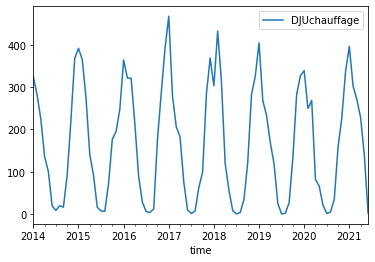

In [13]:
DJUchauffage.plot(y = 'DJUchauffage')
plt.savefig("P9_DJUchauffage.png")

In [14]:
DJUclimat= pd.read_csv('DJUclimat2.csv', parse_dates=[0], dayfirst=True)
print(DJUclimat.info())
DJUclimat.set_index('time',inplace=True)
DJUclimat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       96 non-null     datetime64[ns]
 1   DJUclimat  96 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.6 KB
None


,DJUclimat
time,
2014-01-01,0.0
2014-02-01,0.0
2014-03-01,0.0
2014-04-01,0.0
2014-05-01,2.2


In [15]:
energy = pd.read_csv("DA_P9_conso energy_monthly.csv", parse_dates=[0], dayfirst=True)
print(energy.info())
energy.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Mois                                      1403 non-null   datetime64[ns]
 1   Qualité                                   1403 non-null   object        
 2   Territoire                                1403 non-null   object        
 3   Production totale                         1403 non-null   int64         
 4   Production nucléaire                      913 non-null    float64       
 5   Production thermique totale               1403 non-null   int64         
 6   Production thermique charbon              974 non-null    float64       
 7   Production thermique fioul                1403 non-null   int64         
 8   Production thermique gaz                  1403 non-null   int64         
 9   Production hydraulique        

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0


In [16]:
Energy = energy[energy['Territoire']=='Ile-de-France'][['Mois','Consommation totale']].rename({'Consommation totale':'consom_total'}, axis=1)
Energy = Energy.iloc[12:, :]
Energy.set_index("Mois", inplace= True)
#Energy=Energy.rename({'Mois':'time'}, axis=1)
print(Energy.info())
Energy.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2014-01-01 to 2021-11-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   consom_total  95 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB
None


,consom_total
Mois,
2014-01-01,7612
2014-02-01,6749
2014-03-01,6509
2014-04-01,5396
2014-05-01,5279


In [17]:
DJU= pd.merge(DJUclimat, DJUchauffage,left_index=True, right_index=True)
DJU.tail()

,DJUclimat,DJUchauffage
time,,
2021-02-01,0.0,302.8
2021-03-01,0.2,271.0
2021-04-01,0.9,228.3
2021-05-01,5.1,138.3
2021-06-01,47.6,1.4


In [18]:
df= pd.merge(DJU, Energy, left_index=True, right_index=True)
df.index.names= ['time']
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2014-01-01 to 2021-06-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DJUclimat     90 non-null     float64
 1   DJUchauffage  90 non-null     float64
 2   consom_total  90 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 2.8 KB
None


,DJUclimat,DJUchauffage,consom_total
time,,,
2014-01-01,0.0,324.4,7612
2014-02-01,0.0,281.9,6749
2014-03-01,0.0,223.9,6509
2014-04-01,0.0,135.5,5396
2014-05-01,2.2,100.2,5279


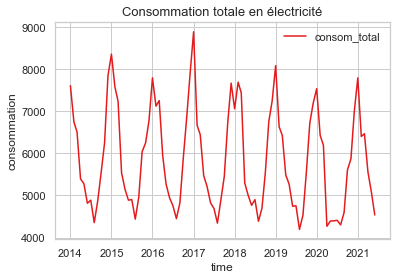

<Figure size 432x288 with 0 Axes>

In [19]:
plt.style.use('seaborn-whitegrid')
sns.set(style='whitegrid', palette='Set1')

sns.lineplot(data=df, x=df.index, y='consom_total', label= 'consom_total')
plt.title("Consommation totale en électricité", fontsize=13)
#plt.xlabel("time")
plt.ylabel('consommation')
plt.legend()
plt.show()
plt.savefig("P9Q0_conso totale.png")

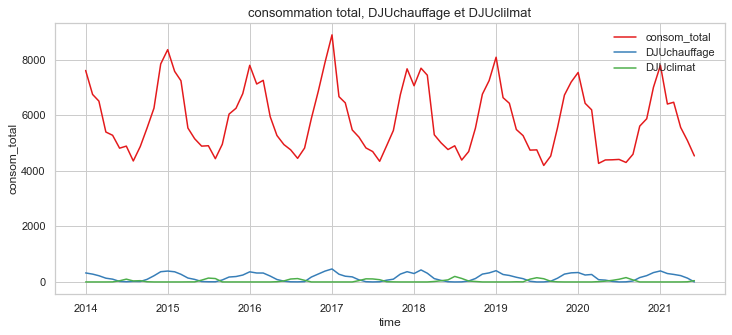

<Figure size 432x288 with 0 Axes>

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
ax1= sns.lineplot(data=df, x=df.index, y='consom_total', label= 'consom_total')
ax2= sns.lineplot(data=df, x=df.index, y='DJUchauffage', label= 'DJUchauffage')
ax3= sns.lineplot(data=df, x=df.index, y='DJUclimat', label= 'DJUclimat')
plt.title("consommation total, DJUchauffage et DJUclilmat", fontsize=13)
#plt.xlabel("time")
#plt.ylabel('effet')
plt.legend()
plt.show()
plt.savefig("P9Q0_conso et dju.png")

* ici les DJU me semblent pas mesurés sur la même échelle que consom_total. Et conjointement comme ce qui est révelé dans rég linéaire après, il y a un coeff de corrélation qui donne effet multiplicatif. Donc je trouve pas assez pertinent de plotter ces 3 variables dans une même graphique. 

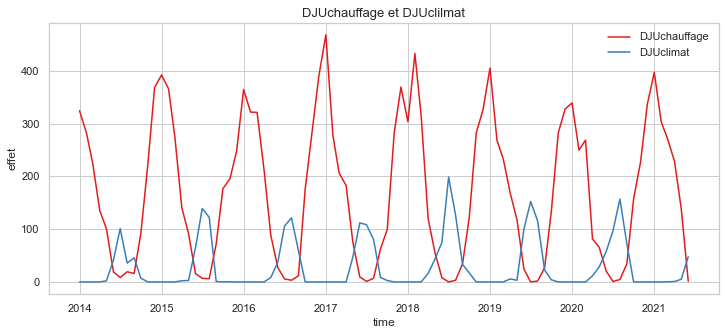

<Figure size 432x288 with 0 Axes>

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
#ax1= sns.lineplot(data=df, x=df.index, y='consom_total', label= 'consom_total')
ax2= sns.lineplot(data=df, x=df.index, y='DJUchauffage', label= 'DJUchauffage')
ax3= sns.lineplot(data=df, x=df.index, y='DJUclimat', label= 'DJUclimat')
plt.title("DJUchauffage et DJUclilmat", fontsize=13)
#plt.xlabel("time")
plt.ylabel('effet')
plt.legend()
plt.show()
plt.savefig("P9Q0_dju.png")

### Q1: Corrigez les données de consommation mensuelles de l'effet température dues au chauffage électrique en utilisant une régression linéaire.

In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from scipy import stats

In [23]:
reg = smf.ols('consom_total~  DJUchauffage', data=df).fit()                   
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           consom_total   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1447.
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           2.06e-56
Time:                        15:44:10   Log-Likelihood:                -636.51
No. Observations:                  90   AIC:                             1277.
Df Residuals:                      88   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4438.6175     48.283     91.930      0.000    4342.666    4534.569
DJUchauffage     8.4668      0.223     38.035      0.000       8.024       8.909
==============================================================================
Omnibus:                        6.783   Durbin-Watson:                   1.382
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.165
Skew:                          -0.593   Prob(JB):                       0.0458
Kurtosis:                       3.488   Cond. No.                         344.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P-value <0.5% => rejet de H0, DJUchauffage a de l'impact sur consom_total.

ce model avec DJUchauffage (temperature) comme variable explicative arrive à expliquer 94.3% de variance en consom_total

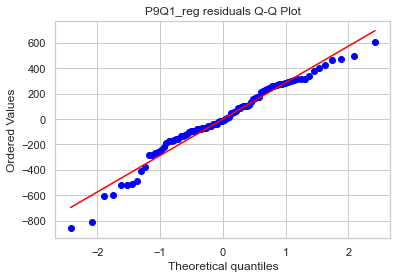

In [24]:
# 1. vérifier la normalité des résidus du model reg 

stats.probplot(reg.resid, dist="norm", plot= plt)
plt.title("P9Q1_reg residuals Q-Q Plot")
plt.savefig("reg_Residuals_qqplot.png")

# Grande superposition de bleue avec ligne rouge => condition normalité est valide.

In [25]:
#2. vérifier homosétasticité des résidus  -  reg
from statsmodels.compat import lzip
import statsmodels

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(reg.resid, reg.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 0.5205145718556348),
 ('p-value', 0.4706222628074068),
 ('f-value', 0.5119082000094789),
 ('f p-value', 0.47620807233808404)]

H0: homoscédasticité des résidus (non-présence de l'hétéroscédasticité, les résidus sont distribués de variance pareille) 

P-value > 5%  => non-rejet de H0, ctd. homoscédasticité pour les résidus du modèle reg 

In [26]:
reg.params['DJUchauffage']        #coeff de reg pour DJUchauffage 

8.466812299186

    équation : (théorique, selon prédiction via reg) 
    consom (théorique, modelized & predicted as per model) = 8.4668* DJUchauffage + 4438.6175
    Residuals = observed - predicted 

In [27]:
reg2 = smf.ols('consom_total~ DJUchauffage + DJUclimat', data=df).fit()       
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           consom_total   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     806.3
Date:                Mon, 25 Apr 2022   Prob (F-statistic):           7.07e-57
Time:                        15:44:18   Log-Likelihood:                -631.40
No. Observations:                  90   AIC:                             1269.
Df Residuals:                      87   BIC:                             1276.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4240.4917     76.546     55.398      0.000    4088.348    4392.635
DJUchauffage     9.1505      0.299     30.596      0.000       8.556       9.745
DJUclimat        2.8211      0.872      3.234      0.002       1.087       4.555
==============================================================================
Omnibus:                        7.095   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.701
Skew:                          -0.654   Prob(JB):                       0.0351
Kurtosis:                       3.272   Cond. No.                         575.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# 1. vérifiez la collinéarité des variables explicatives - reg2
df.corr()
#sns.heatmap(df.corr(),linewidths=0.1)
#plt.savefig("P9Q1_df_heatmap_colinearity.png")

,DJUclimat,DJUchauffage,consom_total
DJUclimat,1.000000,-0.706928,-0.630884
DJUchauffage,-0.706928,1.000000,0.970906
consom_total,-0.630884,0.970906,1.000000


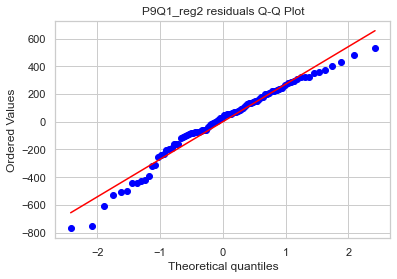

In [29]:
# 2. vérifier la normalité des résidus - reg2
stats.probplot(reg2.resid, dist="norm", plot= plt)
plt.title("P9Q1_reg2 residuals Q-Q Plot")
plt.savefig("reg2_Residuals_qqplot.png")

In [30]:
# 3. vérifier homoscétasticité des résidus - reg2
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(reg2.resid, reg2.model.exog)
lzip('reg2', name, test)

[('r', 'Lagrange multiplier statistic', 0.8346853429817336),
 ('e', 'p-value', 0.6587951309509059),
 ('g', 'f-value', 0.40720780899355646),
 ('2', 'f p-value', 0.666767636817603)]

normalité et homoscédasticité vérifiées. 

reg2 a ses 2 variables explicatives fortement corrélées, et reg2 n'est pas bcp mieux que reg en variance expliquée, donc on pourrait utiliser reg.

### Calcul: 
#### consomation corrigée de DJUchauffage =  conso totale - DJUchauffage*coeff DJUchauffage .           
*should not take intercept(about the whole equation) into calculation 


In [31]:

# consom corrigée de l'impact DJUchauffage
df['conso_corrected'] = df['consom_total'] - df['DJUchauffage']*reg.params['DJUchauffage']     
df.head()

,DJUclimat,DJUchauffage,consom_total,conso_corrected
time,,,,
2014-01-01,0.0,324.4,7612,4865.366090
2014-02-01,0.0,281.9,6749,4362.205613
2014-03-01,0.0,223.9,6509,4613.280726
2014-04-01,0.0,135.5,5396,4248.746933
2014-05-01,2.2,100.2,5279,4430.625408


In [32]:
df.describe()

,DJUclimat,DJUchauffage,consom_total,conso_corrected
count,90.000000,90.000000,90.000000,90.000000
mean,29.402222,168.476667,5865.077778,4438.617464
std,47.089437,137.365660,1197.901576,286.852937
min,0.000000,0.000000,4193.000000,3577.801479
25%,0.000000,24.975000,4836.500000,4306.675282
50%,0.950000,149.300000,5537.500000,4427.718871
75%,45.075000,282.575000,6755.750000,4667.509898
max,198.700000,467.900000,8894.000000,5042.009579


In [313]:
#df.tail(12)

In [24]:
#df2 = df.iloc[:- 6 , :]     # drop the last 6 observations 
#df2

# 12*7

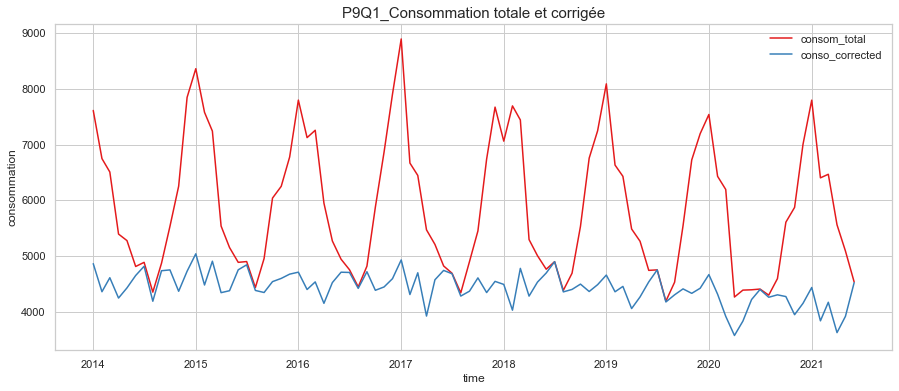

<Figure size 432x288 with 0 Axes>

In [33]:
plt.style.use('seaborn-whitegrid')
sns.set(style='whitegrid', palette='Set1')
fig, ax = plt.subplots(figsize=(15,6))

ax1= sns.lineplot(data=df, x=df.index, y='consom_total', label= 'consom_total')
ax2= sns.lineplot(data=df, x=df.index, y='conso_corrected', label= 'conso_corrected')
plt.title("P9Q1_Consommation totale et corrigée", fontsize=15)
#plt.xlabel("time")
plt.ylabel("consommation")
plt.legend()
plt.show()
plt.savefig("P9Q1_Consommation totale et corrigée.png")

## 2. Désaisonnalisation de la consommation obtenue après correction en Q1 ('conso_corrected') 

Time series has 3 components : 
- trend (tendance, le niveau moyen de la time series ) 
- seasonnality ( fluctuation périodique dans la serie, cyclique) 
- residual (la part qu'on ne peut pas expliquer via model en question)

### 2.1 Désaisonnalisation via algorithme: seasonal_decompose

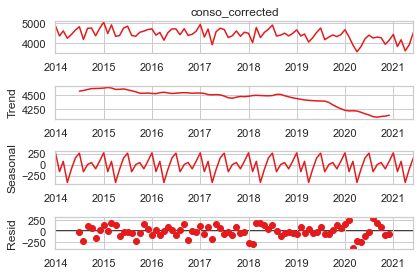

<Figure size 432x288 with 0 Axes>

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_x = seasonal_decompose(df['conso_corrected'],  model='add')    # x: conso_corrected avant désaisonnalisation 
decomp_x.plot()
#plt.title('P9Q2_décomposition de conso_corrected via seasonal_decompose')
plt.show()
plt.savefig("P9Q2_decomposition x_conso_corrected.png")

# ici on observe que l'ampleur de saisonnalité ne change pas avec le temps,donc on opte pour 'additive':
#https://www.daitan.com/innovation/exponential-smoothing-methods-for-time-series-forecasting/

In [35]:
desaison = df.copy()
desaison = desaison.drop(['DJUclimat', 'DJUchauffage', 'consom_total'], axis=1)
desaison.head(1)


,conso_corrected
time,
2014-01-01,4865.36609


In [36]:
desaison['corrected_desaison'] = desaison['conso_corrected'] - decomp_x.seasonal.values
desaison.head(1)

,conso_corrected,corrected_desaison
time,,
2014-01-01,4865.36609,4590.277379


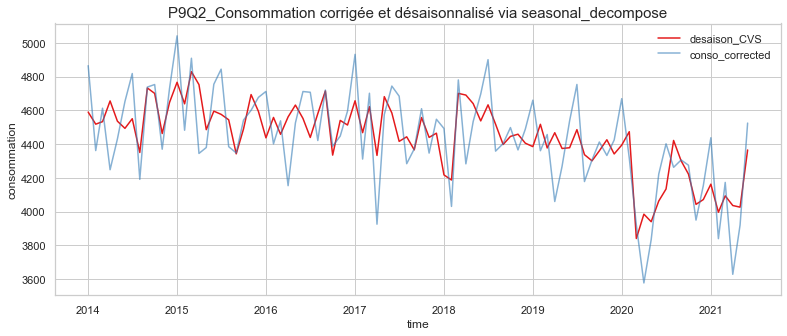

<Figure size 432x288 with 0 Axes>

In [37]:
fig, ax = plt.subplots(figsize=(13,5))
ax1= sns.lineplot(data=desaison, x=desaison.index, y='corrected_desaison', label= 'desaison_CVS')
ax2= sns.lineplot(data=desaison, x=desaison.index, y='conso_corrected', label= 'conso_corrected', alpha=0.6)
plt.title("P9Q2_Consommation corrigée et désaisonnalisé via seasonal_decompose", fontsize=15)
#plt.xlabel("time")
plt.ylabel("consommation")
plt.legend()
plt.show()
plt.savefig("P9Q2_Consommation corrigée et desaisonnalisée_decompose.png")

### 2.2 Correction de Variation Saisonnière (désaisonnalisation) via régression linéaire


In [53]:
desaison2 = df.copy()
desaison2 = desaison2.drop(['DJUclimat', 'DJUchauffage', 'consom_total'], axis=1)
x = desaison2 
#y = np.log(x)  
x.tail()

,conso_corrected
time,
2021-02-01,3840.249236
2021-03-01,4173.493867
2021-04-01,3629.026752
2021-05-01,3921.039859
2021-06-01,4525.146463


In [54]:
t = range(1, 91)           # t: base tendancielle 

for i in range(12):
    su = np.repeat(0, repeats=12)
    su[i] = 1
    s = np.tile(su, 90 // len(su) + 1)[: 90]
    vars()['s' + str(i+1)] = s                  # s: base saisonnière 

In [40]:
from sklearn import linear_model

Reg = linear_model.LinearRegression(fit_intercept=False)
Reg.fit(np.array([t, s1, s2, s3, s4, s5, s6, s7,s8]).transpose(), x)

LinearRegression(fit_intercept=False)

In [41]:
s


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0])

In [42]:
Reg.coef_   

array([[  45.13758774, 2785.88008106, 2277.61477941, 2480.7517421 ,
        1951.78619254, 2187.56003976, 2439.47598914, 2789.50610983,
        2311.63758611]])

In [43]:
a = np.mean(Reg.coef_[0][1:9])      # mean of reg.coef of all the 8 years : espérance 
b = Reg.coef_[0][0]     
c = Reg.coef_[0][1:9] - a                 # distances de chaque année avec l'espérance 

print(a)
print(b)
print(c)

2403.0265649930643
45.13758774345287
[ 382.85351607 -125.41178558   77.72517711 -451.24037246 -215.46652523
   36.44942415  386.47954484  -91.38897888]


In [44]:
x_cvs = x['conso_corrected'] - (c[0]*s1+c[1]*s2+c[2]*s3+c[3]*s4+c[4]*s5+c[5]*s6+c[6]*s7+c[7]*s8)                   # c : coeff initiaux de reg 


corrigées des variations saisonnières (CVS)

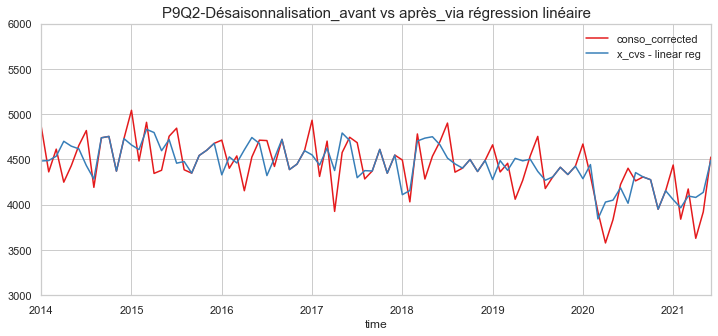

<Figure size 432x288 with 0 Axes>

In [45]:
x.plot(figsize=(12,5),legend= True)                      
x_cvs.plot(legend = True, label='x_cvs - linear reg') 
plt.ylim(3000,6000)
#plt.yscale('log')
plt.title('P9Q2-Désaisonnalisation_avant vs après_via régression linéaire', fontsize=15)
plt.show()
plt.savefig("P9Q2_x cvs_by linear reg.png")

### Q2.3: Correction de Variation Saisonnière (désaisonnalisation) via méthode moyennes mobiles (rolling mean) 

In [56]:
# test the stationarity before rolling mean diffrencing [conso_corrected]
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(X['conso_corrected'].dropna(), autolag = 'AIC')                                            
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  0.30891852319316454
2. P-Value :  0.97774998312691
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 77
5. Critical Values :
	 1% :  -3.518281134660583
	 5% :  -2.899878185191432
	 10% :  -2.5872229937594873


ADF > Critical values at level 1% 5% and even10% => non-rejection of H0, la série *conso_corrected* est non-stationnaire

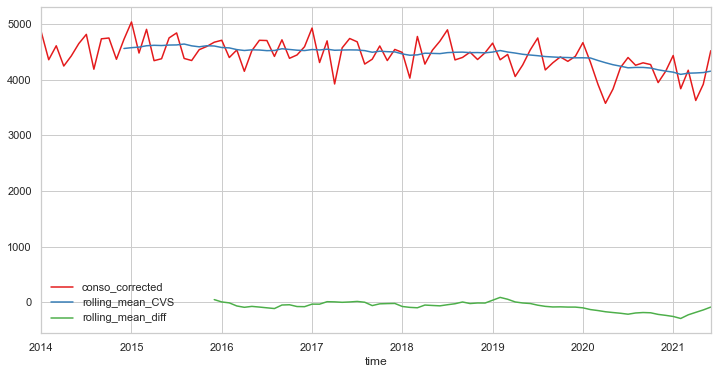

<Figure size 432x288 with 0 Axes>

In [55]:
X= desaison2.copy()
X['rolling_mean_CVS'] = X.rolling(window=12).mean()                              #  Size of the moving window. calculate rolling mean for every 12 former observations. Larger size means more smoothed rolling mean line
X['rolling_mean_diff'] = X['rolling_mean_CVS'] - X['rolling_mean_CVS'].shift(12)   # process differencing.['rolling_mean_diff'] is the difference of rolling mean. shift(1): by default 1, difference between actual step & last 1 step

#différenciation: shift(12): difference between current time step & 12 last steps

X.plot(figsize=(12,6))
plt.title('')
plt.show()
plt.savefig("P9Q2_rolling mean_X CVS.png")

Here we can see in the graph the seasonality of before the differencing and after the differencing. 
We can see:
- the data after rolling mean rolling_mean_CVS is stationary, that's because we have reduced a lot of seasonality, now its the trend. (we're going to use it in ARMA SARIMA..)
- rolling_mean_diff is almost constant, it's the mean of residuals (which is expected to be 0 ideally).

In [58]:
#X.head(13)

moyenne mobile simple (arithmétique)  symétrique et normalisée ? ? 

In [59]:
# test the stationarity after rolling mean process

dftest2 = adfuller(X['rolling_mean_diff'].dropna(), autolag = 'AIC')                                             #X['rolling_mean_CVS'] is data corrected of seasonality via process rolling mean, it's the trend  # ['rolling_mean_diff'] is the residuals of rolling_mean 
print("1. ADF : ",dftest2[0])
print("2. P-Value : ", dftest2[1])
print("3. Num Of Lags : ", dftest2[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest2[3])
print("5. Critical Values :")
for key, val in dftest2[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.9996165036740192
2. P-Value :  0.28674127425561513
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 65
5. Critical Values :
	 1% :  -3.5352168748293127
	 5% :  -2.9071540828402367
	 10% :  -2.5911025443786984


**Augmented Dickey–Fuller test:** 

H0: a unit root is present in a time series sample (time series is non-stationnary )

Ha: no unit root, stationnary.

If the calculated test statistic is less (more negative) than the critical value, then the H0  is rejected and no unit root is present. In this case ideally we wish H0 being rejected. 


<font color= 'ED3245'> 
    ADF > Critical values at level 1% 5% and even10% => non-rejection of H0, la série est non-stationnaire, blancheur des résidus non-vérifiée. Ctd. il existe tjrs de l'autocorrélation dans la série temporelle. 
    
 Vu que ARMA ne peut que modéliser les processus stationnaire. Comment faire? SARIMA </font>  

### Comparaison de ces 2 méthodes_linear reg vs rolling mean
Selon les résultats de ces 2 méthodes (régression linéare et moyennes mobiles), on constate que moyennes mobiles (différenciation) est plus adéquate pour désaisonnaliser les données brutes car: 
- rolling().mean() can be parametered easily: window, shift 
- linear reg is not a good fit in case there're half-cycle data observations


### 3. Prévision de la consommation (corrigée de l'effet température) sur un an 

- 3.1. méthode de Holt Winters (lissage exponentiel) 
- 3.2. méthode SARIMAX

Pourquoi ces deux méthodes sont toutes adéquates pour ce faire ? 
- ExponentialSmoothing attache plus d'importance aux données récentes que les plus anciennes.  Ici on envisage prédire la consommation électrique qui fluctue bcp dans le temps. 
- SARIMA permet de modéliser les séries qui présentent la saisonnalité (non-stationnaire). 

### 3.1 Prévision de la consommation à l'aide de lissage exponentiel

In [60]:
from statsmodels.tsa.api import ExponentialSmoothing

In [61]:
pd.date_range(X.index[X.shape[0]-1], periods=12, freq='M')

DatetimeIndex(['2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
               '2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31'],
              dtype='datetime64[ns]', freq='M')

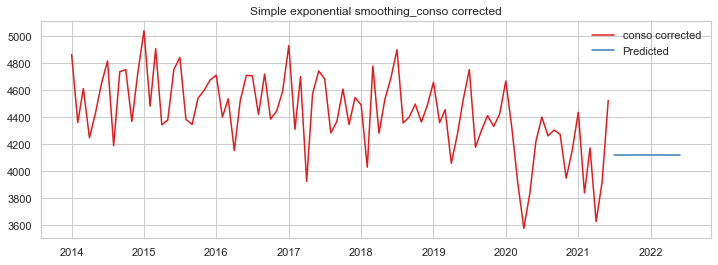

<Figure size 432x288 with 0 Axes>

In [62]:
les = ExponentialSmoothing(np.asarray(X["conso_corrected"]),  trend=None, seasonal=None).fit()
les_pred = les.forecast(12)

plt.figure(figsize=(12,4))
plt.plot(X['conso_corrected'], label='conso corrected')  
plt.plot(pd.date_range(X.index[len(X)-1], periods=12,  freq='M'), les_pred, label='Predicted')    #LES: Lissage Exponentiel Simple    freq="M": month end frequency   periods=12,  freq='M': 12 months 
# freq can be : D, M, A (day, month, year), periods=12, freq='M' means predict the future 12 months

plt.legend()
plt.title('Simple exponential smoothing_conso corrected')
plt.show()
plt.savefig("P9Q3_exponential smoothing_simple.png")

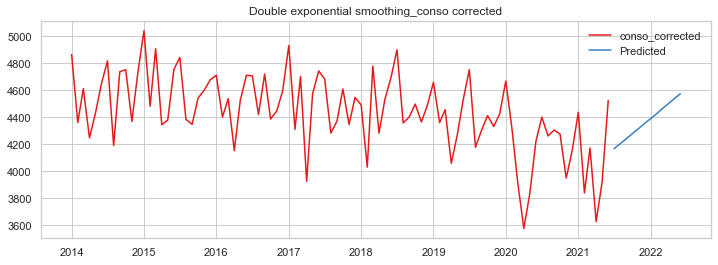

<Figure size 432x288 with 0 Axes>

In [63]:
led = ExponentialSmoothing(np.asarray(X["conso_corrected"]), trend='add', seasonal=None).fit()    #LED: Lissage Exponentiel Double  ici 'trend' is also additive according to seasonal_decompose, if it's mul, then the trend would be exponential 
led_pred = led.forecast(12)

plt.figure(figsize=(12,4))
#plt.gcf().autofmt_xdate()
plt.plot( X["conso_corrected"], label="conso_corrected")
plt.plot(pd.date_range(X.index[X.shape[0] -1], periods=12, freq='M'), led_pred, label='Predicted')   
plt.legend()
plt.title('Double exponential smoothing_conso corrected')
plt.show()
plt.savefig("P9Q3_exponential smoothing_double.png")

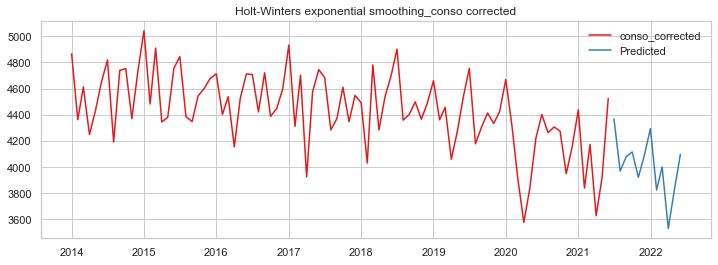

<Figure size 432x288 with 0 Axes>

In [64]:
hw = ExponentialSmoothing(np.asarray(X["conso_corrected"]), seasonal_periods=12, trend='add', seasonal='add').fit()      # additive 
hw_pred = hw.forecast(12)

plt.figure(figsize=(12,4))
#plt.gcf().autofmt_xdate()
plt.plot(X["conso_corrected"], label="conso_corrected")
plt.plot(pd.date_range(X.index[X.shape[0] -1], periods=12, freq='M'), hw_pred, label='Predicted')   # HW: méthode lissage Holt-Winters
plt.legend()
plt.title('Holt-Winters exponential smoothing_conso corrected')
plt.show()
plt.savefig("P9Q3_exponential smoothing_HW.png")

#### Holt-Winters: analyse à posteriori

In [65]:
# vérifier le niveau de précision de model Holt-Winters sur une période passée (2021)
X_test =  X['conso_corrected']
X_past = X_test[:'2019']
X_forecast = X_test['2020':'2021'] 
print(X_forecast.shape)

(18,)


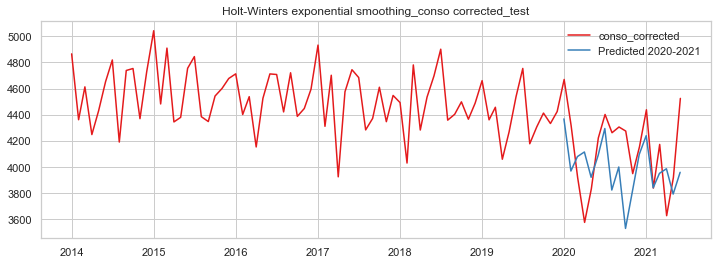

<Figure size 432x288 with 0 Axes>

In [66]:
hwpast = ExponentialSmoothing(np.asarray(X_past), seasonal_periods=12, trend='add', seasonal='add').fit()      # additive 
hwpast_pred = hw.forecast(18)                         

plt.figure(figsize=(12,4))
plt.plot(X_test, label="conso_corrected")
plt.plot(pd.date_range(X_past.index[X_past.shape[0] -1], periods=18, freq='M'), hwpast_pred, label='Predicted 2020-2021')   # HW: méthode lissage Holt-Winters
# preiods= 30: forecast the future 30 periods, unit is month

plt.legend()
plt.title('Holt-Winters exponential smoothing_conso corrected_test')
plt.show()
plt.savefig("P9Q3_exponential smoothing_HW_test.png")

In [67]:
# accuracy test via metrics
from sklearn.metrics import * 

print('MAE_HW:', mean_absolute_error(X_forecast, hwpast_pred))                                           # importance d'une erreur est linéaire avec son amplitude, si le dataset contient des valeurs aberrantes (outliers)
print('RMSE_HW:', np.sqrt(mean_squared_error(X_forecast, hwpast_pred)))                           # Root Mean Squared Error: more reasonable than MSE , additive 
print('MAPE_HW', mean_absolute_percentage_error(X_forecast, hwpast_pred)*100, '%')        # MAPE:  puts a heavier penalty on negative errors than on positive errors; For forecasts which are too low the percentage error cannot exceed 100%, but for forecasts which are too high there is no upper limit to the percentage error. Strong point: very intuitive interpretation on relative error. Weak point: 


MAE_HW: 267.92226967935557
RMSE_HW: 331.15716772004475
MAPE_HW 6.465679977815281 %


In [68]:
print('accuracy score HW:', round((1-mean_absolute_percentage_error(X_forecast, hwpast_pred)), 4)*100,'%')

accuracy score HW: 93.53 %


### test auto-correlation of time series (test de blancheur du résidu) avec ljungbox test (similaire avec adfuller) 

- H0: The residuals are independently distributed, no autocorrelation among residuals, residuals (time series) is stationary

- HA: The residuals are not independently distributed; they exhibit serial correlation.

ideally we expect the P-value >5% so as to conclude the non-rejection of H0.

### 3.2 Prévision de la consommation à l’aide de méthode SARIMAX

- ARIMA(AutoRegressive Moving Average) nécessite the la série temporelle soit stationnaire,

- alors que SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors) n'exige pas la stationnarité de série temporelle vu que dans son aglorithme, la saisonnalité et toute autre facteur exogène sont prise en compte. 

C'est pourquoi ici on a opté  SARIMAX.

#### Interprétation SARIMAX: 

order=(P,D,Q):(1,1,1)

    D: is the parameter associated with the *integrated* part of the model, which effects the amount of differencing to apply to a time series. To what level the values of different time points are intergrated/linked one another?

(ordre de différenciation AR, ordre tendance stable, ordre de différenciation MA) 

seasonal_order=(P,D,Q,s): (1,1,1, s)

(ordre de différenciation AR, ordre saisonnalité stable, ordre de différenciation MA, quantité de mois pour un cycle) 

How to choose the parameters (P,D,Q) ? 
1. ACF PACF : 
https://people.duke.edu/~rnau/arimrule.htm
2. auto_arima
https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/

https://pypi.org/project/pmdarima/ pmdarima 


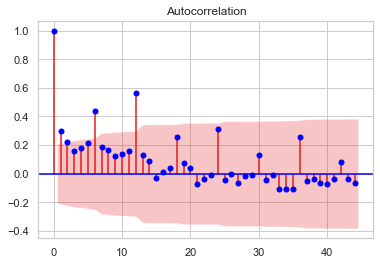

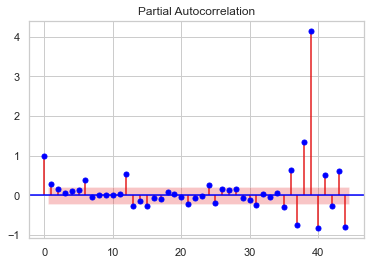

<Figure size 432x288 with 0 Axes>

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(x['conso_corrected'],lags=44, color='b')
plot_pacf(x['conso_corrected'], lags=44, color='b')
plt.show()
plt.savefig('P9Q3_ACF PACF')

Selon graphique ACF, on voit que la saisonnalité est toute les 12 mois; 

Et selon ces 2 graphiques ACF et PACF, on en résume que un AR(1) model sera bon.

#### model 1 
SARIMAX(1,1,1)(1,1,1,12)

In [70]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox                                  # Ljung-Box test of autocorrelation in residuals.

model1 = SARIMAX(np.asarray(x['conso_corrected']), order=(1,1,1), seasonal_order=(1,1,1,12))
results1 = model1.fit()
results1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -508.414
Date:                            Mon, 25 Apr 2022   AIC                           1026.828
Time:                                    15:55:06   BIC                           1038.547
Sample:                                         0   HQIC                          1031.515
                                             - 90                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2399      0.154      1.562      0.118      -0.061       0.541
ma.L1         -0.8819      0.090     -9.829      0.000      -1.058      -0.706
ar.S.L12       0.0353      0.145      0.243      0.808      -0.250       0.320
ma.S.L12      -0.9993      0.124     -8.045      0.000      -1.243      -0.756
sigma2      2.266e+04   5.49e-06   4.13e+09      0.000    2.27e+04    2.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                15.25
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                            -0.61
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.6e+24. Standard errors may be unstable.
"""

H0: il existe dans ce model des paramètres non-significatifs

(selon P >IzI) Ce modèle ayant des paramètres non significatifs, on en teste un second model.  


#### model2
SARIMAX(1,1,1)(0,1,1,12)

In [71]:
model2 = SARIMAX(np.asarray(x['conso_corrected']), order=(1,0,1), seasonal_order=(1,1,1,12))   # where the difference from model1
results2 = model2.fit()
results2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -515.145
Date:                            Mon, 25 Apr 2022   AIC                           1040.290
Time:                                    15:55:17   BIC                           1052.073
Sample:                                         0   HQIC                          1045.007
                                             - 90                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9773      0.035     27.593      0.000       0.908       1.047
ma.L1         -0.8025      0.056    -14.296      0.000      -0.913      -0.692
ar.S.L12       0.1442      0.144      1.003      0.316      -0.137       0.426
ma.S.L12      -0.9989      0.133     -7.538      0.000      -1.259      -0.739
sigma2      2.435e+04   5.45e-06   4.47e+09      0.000    2.44e+04    2.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.92   Jarque-Bera (JB):                 7.34
Prob(Q):                              0.17   Prob(JB):                         0.03
Heteroskedasticity (H):               1.70   Skew:                            -0.55
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+25. Standard errors may be unstable.
"""

Ce modèle ayant des paramètres non significatifs, on en teste un troisième.

#### model3

SARIMAX(1,0,1)(1,0,1,12)

In [72]:
model3 = SARIMAX(np.asarray(x['conso_corrected']), order=(1,0,1), seasonal_order=(1,0,1,12))
results3 = model3.fit()            # training 
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -600.100
Date:                            Mon, 25 Apr 2022   AIC                           1210.201
Time:                                    15:55:21   BIC                           1222.700
Sample:                                         0   HQIC                          1215.241
                                             - 90                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9974      0.010     95.477      0.000       0.977       1.018
ma.L1         -0.8055      0.075    -10.812      0.000      -0.952      -0.660
ar.S.L12       0.9963      0.020     50.563      0.000       0.958       1.035
ma.S.L12      -0.8854      0.291     -3.037      0.002      -1.457      -0.314
sigma2      2.597e+04   4436.588      5.853      0.000    1.73e+04    3.47e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):                 7.78
Prob(Q):                              0.36   Prob(JB):                         0.02
Heteroskedasticity (H):               1.55   Skew:                            -0.55
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

summary SARIMAX p-values are all largely < 5%, so reject H0,  this model3 does not have non-significant parameters. 

In [735]:
#results3.test_heteroskedasticity(None, alternative='two-sided', use_f=True)

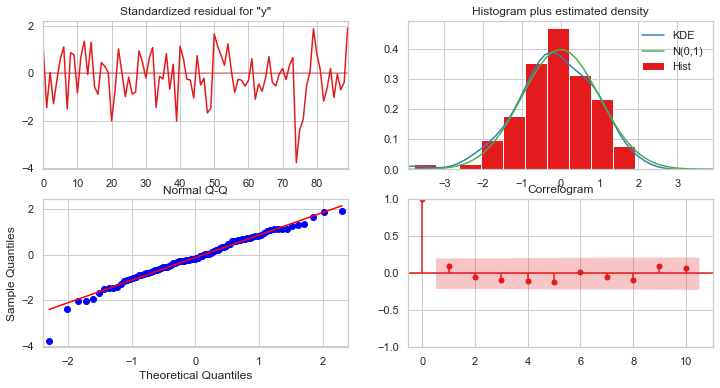

<Figure size 432x288 with 0 Axes>

In [73]:
results3.plot_diagnostics(figsize=(12,6))
plt.show()
plt.savefig("P9Q3_plot_diagnostics_SARIMAX result3.png")

In [74]:
print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36,42]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3.resid, lags=elt)[1].mean()))

Retard : p-value
6 : 0.8121880705345986
12 : 0.8988986457819103
18 : 0.9324244043837187
24 : 0.9493138512965134
30 : 0.9594509696043663
36 : 0.9662091390695718
42 : 0.9710364048354023


Selon summary, conjointement avec plot_diagnostics et ljungbox ci-dessus: 

- normalité de résidus: vérifiée
- homoscédasticité de résidus: vérifiée
- blancheur des résidus: vérifiée (vu que p-value ljungbox >5%, non-rejet de H0); et selon test ljungbox de tous les lags, tous P-values >5%, non-rejet de H0 => non autocorrélation de série , blancheur de résidus vérifiée. 

Donc on peut prédire via model3.

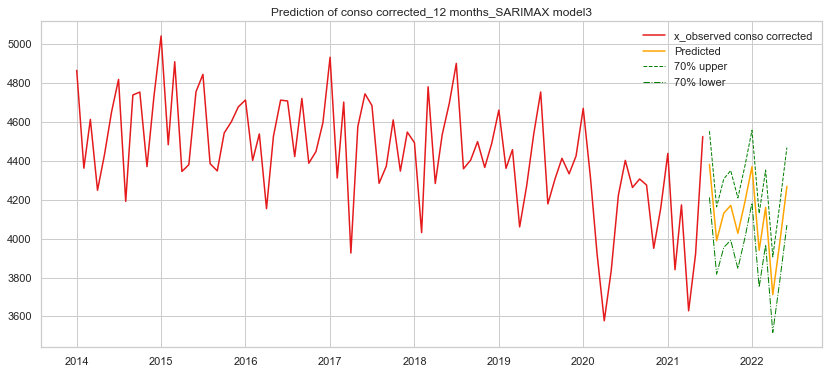

<Figure size 432x288 with 0 Axes>

In [75]:
# prediction with model3
pred_model3 = results3.get_forecast(12)
pred = pred_model3.predicted_mean                                       # average level of prediction 
pred_u = [elt[1] for elt in pred_model3.conf_int(alpha=0.3)]    # upper level  
pred_l = [elt[0] for elt in pred_model3.conf_int(alpha=0.3)]      # lower level , alpha is the (1-precision level)

plt.figure(figsize=(14,6))
plt.plot(x['conso_corrected'], label='x_observed conso corrected')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='orange', label='Predicted')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--',linewidth=1, label='70% upper')  
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_l, color='g', linestyle='-.', linewidth=1, label='70% lower')
plt.title('Prediction of conso corrected_12 months_SARIMAX model3')
plt.legend()
plt.show()
plt.savefig("P9Q3_2_sarimax_prediction x.png")

#### SARIMAX: Analyse à posteriori

pour vérifier la performance de notre model, ici on va faire une comparatif des données observées et ‘prédites’ pour année 2020 

In [76]:
# Vérifier le niveau de précision de model3 via les data d'une période passée

x_past = x['conso_corrected'][:'2019']
# y_past = np.log(x_past) 
x_forecast = x['conso_corrected']['2020']    # ici on va 'prédire' la conso de 2020 à travers ce model

#x_past,x_forecast

In [77]:
# on vérifie que model3 est tjrs validé sur les data past 

model3past = SARIMAX(np.asarray(x_past), order=(1,0,1), seasonal_order=(1,0,1,12))    # same parameters with model3 
results3past = model3past.fit()
results3past.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -471.272
Date:                            Mon, 25 Apr 2022   AIC                            952.544
Time:                                    15:55:41   BIC                            963.927
Sample:                                         0   HQIC                           957.075
                                             - 72                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9996      0.004    244.219      0.000       0.992       1.008
ma.L1         -0.9446      0.146     -6.459      0.000      -1.231      -0.658
ar.S.L12       0.9953      0.035     28.466      0.000       0.927       1.064
ma.S.L12      -0.8633      0.486     -1.778      0.075      -1.815       0.088
sigma2      1.823e+04   6685.301      2.727      0.006    5130.343    3.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.95   Prob(JB):                         0.44
Heteroskedasticity (H):               0.84   Skew:                            -0.21
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36,42]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3past.resid, lags=elt)[1].mean()))

Retard : p-value
6 : 0.810454344825431
12 : 0.8999776202072743
18 : 0.9332418660286999
24 : 0.9499303396479983
30 : 0.9599442538712571
36 : 0.9666202113157887
42 : 0.9713887525455819



SARIMAX p-value <5% , rejet H0 => il n'y a pas de paramètres non significatifs dans ce model.

Ljung-Box test p-values >5% , non-rejet H0 => non autocorrelation de série temporelle, blancheur résidus vérifiée.

=> bon pour faire la prédiction

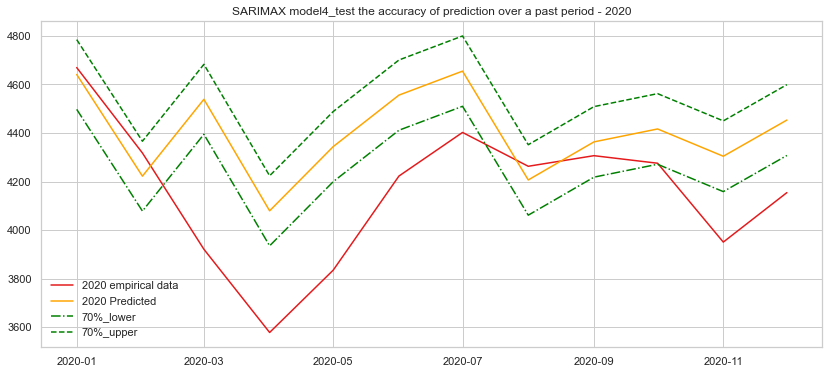

<Figure size 432x288 with 0 Axes>

In [79]:
# Evaluate accuracy of prediction model for year 2020 - via graphics

pred_model3past = results3past.get_forecast(12)
pred_past = pred_model3past.predicted_mean
pred_l_past = [elt[0] for elt in pred_model3past.conf_int(alpha=0.3)]   #niveau de précision 0.7
pred_u_past = [elt[1] for elt in pred_model3past.conf_int(alpha=0.3)]

plt.figure(figsize=(14,6))
plt.plot(x_forecast, label='2020 empirical data')
plt.plot(x_forecast.index, pred_past, color='orange', label='2020 Predicted')
plt.plot(x_forecast.index, pred_l_past, color='g', linestyle='-.', label='70%_lower')
plt.plot(x_forecast.index, pred_u_past, color='g', linestyle='--', label='70%_upper')
plt.title('SARIMAX model4_test the accuracy of prediction over a past period - 2020')
plt.legend()
plt.show()
plt.savefig("P9Q4_test of sarimax prediction.png")

=> En terme de tendance et fluctuation de saisonnalité, ce model4 a une performance satisfaisante. 

In [80]:
# Evaluate accuracy of prediction model for year 2020 - via metrics 

from sklearn.metrics import * 

print('MAE:', mean_absolute_error(x_forecast, pred_past))              # importance d'une erreur est linéaire avec son amplitude, si le dataset contient des valeurs aberrantes (outliers)
print('MSE:', mean_squared_error(x_forecast, pred_past))              # carré, exponentiel. quand on accorde grande importance aux grandes erreurs 
print('RMSE:', np.sqrt(mean_squared_error(x_forecast, pred_past)))   # Root Mean Squared Error: more reasonable than MSE , additive 
print('median abs err:', median_absolute_error(x_forecast, pred_past))     #Median absolute error  = median(IYvrai - Y predI) : très peu sensible aux grande erreur
print('MAPE', mean_absolute_percentage_error(x_forecast, pred_past)*100, '%')        # MAPE:  puts a heavier penalty on negative errors than on positive errors; For forecasts which are too low the percentage error cannot exceed 100%, but for forecasts which are too high there is no upper limit to the percentage error. Strong point: very intuitive interpretation on relative error. Weak point: 


MAE: 270.5459186289376
MSE: 109924.36755772762
RMSE: 331.54843923283306
median abs err: 275.86205359088945
MAPE 6.802266940024825 %


=>Selon ces métriques, on en conclut que model4 est performant. 

In [81]:
print('accuracy score model4:', round((1-mean_absolute_percentage_error(x_forecast, pred_past)), 4)*100,'%')

accuracy score model4: 93.2 %


### Optimal SARIMAX (ARIMA) 

model selection with pmdarima module. 

Automatically discover the optimal order for an ARIMA model.
The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. 

In [83]:
import pmdarima 
# pip install pmdarima in terminal 
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(X['conso_corrected'],
                         test='adf',       #ADFuller test: for stationnarity 
                         m=12,
                         seasonal=True,
                         d=0, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1062.547, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1053.774, Time=0.18 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1047.416, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1066.978, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1058.553, Time=0.04 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1054.549, Time=0.23 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1052.953, Time=0.16 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1040.324, Time=0.51 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1059.783, Time=0.20 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -515.162
Date:                            Mon, 25 Apr 2022   AIC                           1040.324
Time:                                    15:56:23   BIC                           1052.107
Sample:                                         0   HQIC                          1045.041
                                             - 90                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9889      2.441     -0.815      0.415      -6.773       2.795
ar.L1          0.9531      0.053     17.956      0.000       0.849       1.057
ma.L1         -0.7920      0.094     -8.462      0.000      -0.975      -0.609
ma.S.L12      -0.7557      0.251     -3.013      0.003      -1.247      -0.264
sigma2      2.697e+04   4407.609      6.118      0.000    1.83e+04    3.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):                 9.95
Prob(Q):                              0.13   Prob(JB):                         0.01
Heteroskedasticity (H):               1.60   Skew:                            -0.66
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
# SARIMAX(1, 0, 1)x(0, 1, 1, 12)  is the optimal choice 
model4 = SARIMAX(np.asarray(x['conso_corrected']), order=(1,0,1), seasonal_order=(0,1,1,12))
results4 = model4.fit()            # training 
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   90
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -515.834
Date:                            Mon, 25 Apr 2022   AIC                           1039.667
Time:                                    16:05:13   BIC                           1049.094
Sample:                                         0   HQIC                          1043.441
                                             - 90                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9838      0.029     33.418      0.000       0.926       1.041
ma.L1         -0.7932      0.051    -15.580      0.000      -0.893      -0.693
ma.S.L12      -0.9987      0.119     -8.379      0.000      -1.232      -0.765
sigma2      2.351e+04   5.08e-06   4.62e+09      0.000    2.35e+04    2.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.25   Jarque-Bera (JB):                11.90
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.64
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.05e+24. Standard errors may be unstable.
"""

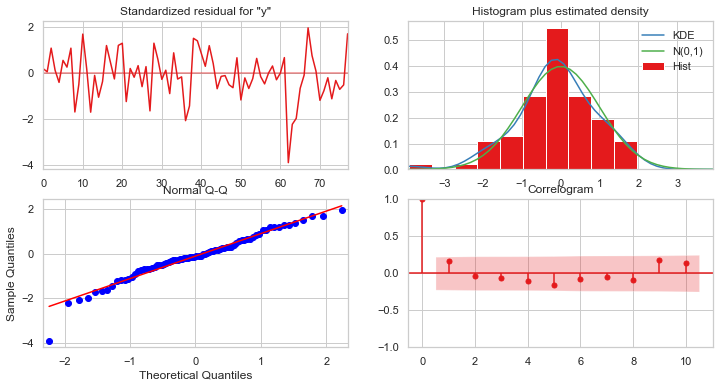

<Figure size 432x288 with 0 Axes>

In [85]:
results4.plot_diagnostics(figsize=(12,6))
plt.show()
plt.savefig("P9Q3_plot_diagnostics_SARIMAX result4.png")

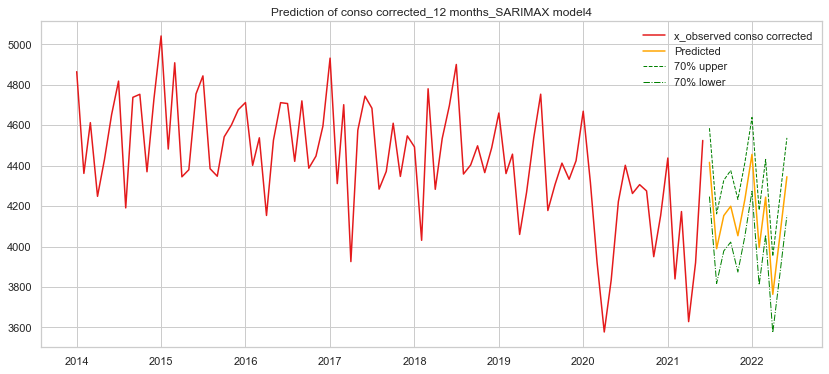

<Figure size 432x288 with 0 Axes>

In [86]:
# prediction with model4
pred_model4 = results4.get_forecast(12)
pred = pred_model4.predicted_mean                                       # average level of prediction 
pred_u = [elt[1] for elt in pred_model4.conf_int(alpha=0.3)]    # upper level  
pred_l = [elt[0] for elt in pred_model4.conf_int(alpha=0.3)]      # lower level , alpha is the (1-precision level)

plt.figure(figsize=(14,6))
plt.plot(x['conso_corrected'], label='x_observed conso corrected')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='orange', label='Predicted')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--',linewidth=1, label='70% upper')  
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_l, color='g', linestyle='-.', linewidth=1, label='70% lower')
plt.title('Prediction of conso corrected_12 months_SARIMAX model4')
plt.legend()
plt.show()
plt.savefig("P9Q3_sarimax_prediction x with model4.png")

In [549]:
# END